# ENSF 611 - Final Project - Will it rain tomorrow?
Author: Davis Allan, 10016543

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In this project, I am going to be using our Lab 3 as a template to solve the classifcation task of determining if it is going to rain tomorrow based on weather measurements of today. This data set is for the year 2017 and incorperates measurements from various weather stations all around Austrailia.  

## 0. Function Definitions

In [2]:
from sklearn.model_selection import cross_validate


def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation score of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)

    val = scores['test_score'].mean()
    train = scores['train_score'].mean()

    return (train, val)

In [3]:
def print_grid_search_result(grid_search):
    '''Prints best parameters and mean training and validation scores of a grid search object.
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        scores are printed with 3 decimal places.
        
    '''
    print("Best parameters and their respective values are: ")
    for param in grid_search.best_params_:
        print(f"{param} = {grid_search.best_params_[param]}")
    
    print("Mean training score = {:.3f}".format(grid_search.cv_results_['mean_train_score'][grid_search.best_index_]))
    print("Mean validation score = {:.3f}".format(grid_search.cv_results_['mean_test_score'][grid_search.best_index_]))

In [4]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [5]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    '''
    
    mat = confusion_matrix(y_actual, y_pred)
    sns.heatmap(mat, square=True, annot=True, cbar=False, xticklabels=labels, yticklabels=labels, fmt='d')
    plt.xlabel("predicted value")
    plt.ylabel("true value")
    plt.title(title)

## 1. Load Data

Dataset: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package (24 features, 8466 samples when only using 2017 data)

In [6]:
data = pd.read_csv('weatherAUS2017.csv', header=0)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8466 entries, 0 to 8465
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           8466 non-null   object 
 1   Location       8466 non-null   object 
 2   MinTemp        8382 non-null   float64
 3   MaxTemp        8437 non-null   float64
 4   Rainfall       8369 non-null   float64
 5   Evaporation    2822 non-null   float64
 6   Sunshine       2216 non-null   float64
 7   WindGustDir    7994 non-null   object 
 8   WindGustSpeed  7994 non-null   float64
 9   WindDir9am     7880 non-null   object 
 10  WindDir3pm     8085 non-null   object 
 11  WindSpeed9am   8435 non-null   float64
 12  WindSpeed3pm   8130 non-null   float64
 13  Humidity9am    8358 non-null   float64
 14  Humidity3pm    7903 non-null   float64
 15  Pressure9am    7602 non-null   float64
 16  Pressure3pm    7602 non-null   float64
 17  Cloud9am       4509 non-null   float64
 18  Cloud3pm

In [8]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2017-01-01,Albury,15.5,31.6,0.0,NaN,NaN,WSW,39.0,E,...,25.0,1005.1,1004.1,NaN,NaN,23.4,31.4,No,0.0,No
1,2017-01-02,Albury,14.9,32.0,0.0,NaN,NaN,SE,35.0,SSW,...,30.0,1011.1,1009.9,NaN,NaN,20.6,30.5,No,0.0,No
2,2017-01-03,Albury,13.7,32.0,0.0,NaN,NaN,SE,24.0,SSE,...,30.0,1018.5,1014.7,NaN,NaN,21.1,29.5,No,0.0,No
3,2017-01-04,Albury,16.2,33.0,0.0,NaN,NaN,NNW,26.0,SE,...,29.0,1018.4,1015.4,NaN,NaN,23.9,31.2,No,0.0,No
4,2017-01-05,Albury,18.0,33.5,0.0,NaN,NaN,SSE,35.0,ENE,...,30.0,1017.5,1013.1,NaN,NaN,24.3,32.4,No,0.0,No


### 1.2 Prepare feature matrix and target vector

Since there is a great deal of missing values in the Cloud9am, Cloud3pm, Evaporation, and Sunshine features, I am going to drop those features and see how the model peforms, if it has poor performance I may end up revisiting them. I am also going to drop any rows with null values.

Furthermore, I am interested in keeping things more general and determining if it is going to rain across all of Austrailia (not location or date specific) so I will also drop the Date and Location columns.

In [9]:
data = data.drop(['Cloud9am', 'Cloud3pm', 'Evaporation', 'Sunshine', 'Date', 'Location'], axis= 1)

In [10]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6596 entries, 0 to 8465
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        6596 non-null   float64
 1   MaxTemp        6596 non-null   float64
 2   Rainfall       6596 non-null   float64
 3   WindGustDir    6596 non-null   object 
 4   WindGustSpeed  6596 non-null   float64
 5   WindDir9am     6596 non-null   object 
 6   WindDir3pm     6596 non-null   object 
 7   WindSpeed9am   6596 non-null   float64
 8   WindSpeed3pm   6596 non-null   float64
 9   Humidity9am    6596 non-null   float64
 10  Humidity3pm    6596 non-null   float64
 11  Pressure9am    6596 non-null   float64
 12  Pressure3pm    6596 non-null   float64
 13  Temp9am        6596 non-null   float64
 14  Temp3pm        6596 non-null   float64
 15  RainToday      6596 non-null   object 
 16  RISK_MM        6596 non-null   float64
 17  RainTomorrow   6596 non-null   object 
dtypes: float

After dropping those features and null values, I am still left with 6596 samples, which I think should be enough to train on.

From the Kaggle information page, the target vector of this classifcation task is 'RainTomorrow', and it also mentions that you have to drop the 'RISK_MM' column before training the classifier. To quote from the discussion page as to why it should be removed: 

    "It's also included in the dataset so that, if you wanted to, you could use the dataset to build a regression machine learning model -- instead of classification. 
    In other words, you can use RISK_MM as your target and drop RainTomorrow if you want to treat this as a regression problem instead of a classification problem."

Since I am performing a classifcation problem, I will drop this as well:

In [11]:
data = data.drop('RISK_MM', axis=1)

The column that I am targetting is "RainTomorrow", and the two class names are "Yes" and "No"

In [12]:
y = data['RainTomorrow']
X = data.drop('RainTomorrow', axis=1)

print("X shape = ", X.shape)
print("y shape = ", y.shape)

X shape =  (6596, 16)
y shape =  (6596,)


## 2. Inspect the data

Since there is a mix of categorical and numerical features, I will explore the plots of those features separately. I will create two separate dataframes for the categorical and numerical features to just be used for plotting:

In [13]:
numerical_feat = data.drop(['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'], axis=1)
categorical_feat = data[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']]

### 2.1 Plotting features

<AxesSubplot:xlabel='WindDir3pm', ylabel='count'>

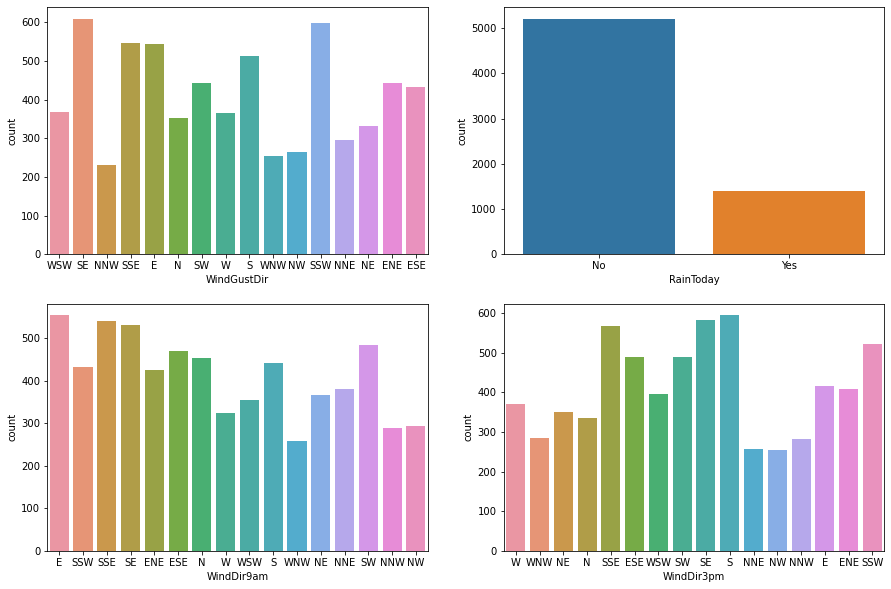

In [14]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

sns.countplot(x='WindGustDir', data=categorical_feat, ax=ax[0][0])
sns.countplot(x='RainToday', data=categorical_feat, ax=ax[0][1])
sns.countplot(x='WindDir9am', data=categorical_feat, ax=ax[1][0])
sns.countplot(x='WindDir3pm', data=categorical_feat, ax=ax[1][1])

<AxesSubplot:>

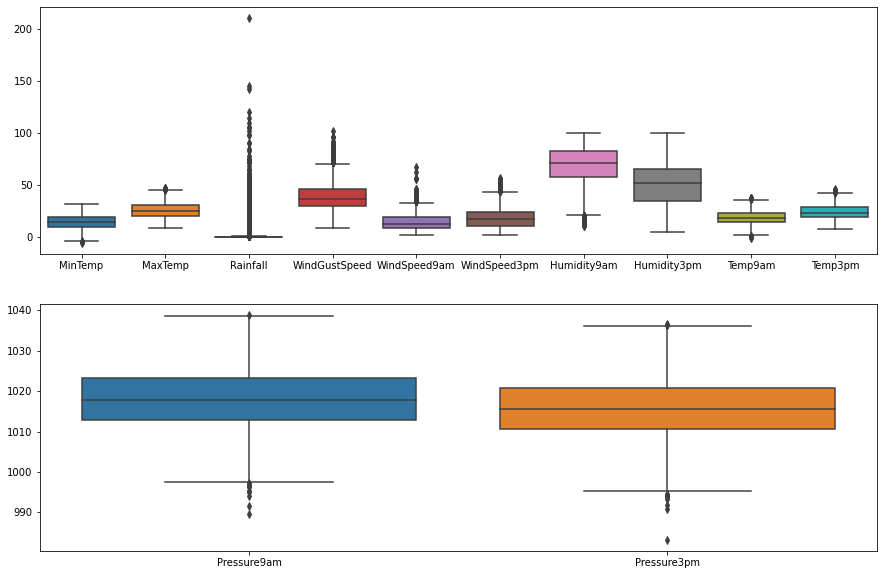

In [15]:
fig, ax = plt.subplots(2,1, figsize=(15,10))

sns.boxplot(data=numerical_feat.drop(['Pressure9am', 'Pressure3pm'], axis=1), ax=ax[0])
sns.boxplot(data=numerical_feat[['Pressure9am', 'Pressure3pm']], ax=ax[1])

Seems to be quite dry in Austrailia since the RainToday has a significantly larger number of 'No' days when compared to 'yes' days. Also it appears that the wind directions seem to be more concentrated from the south and east (another thing I find interesting). 

The numerical data seems to have some significant outliers for the Rainfall, all of the other features seem to have more normal distributions.  

### 2.3 Class (im)balance

In [16]:
y.value_counts()

No     5217
Yes    1379
Name: RainTomorrow, dtype: int64

In [17]:
yes_ratio = 1379 / 6596
no_ratio = 5217 / 6596
print("yes ratio = ", yes_ratio)
print("no ratio = ", no_ratio)

yes ratio =  0.20906610066707096
no ratio =  0.790933899332929


<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

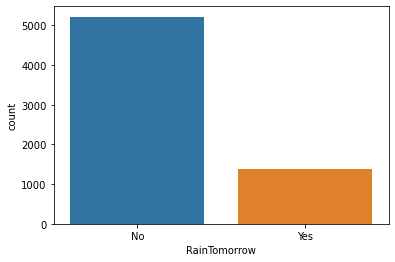

In [18]:
sns.countplot(y)

Given that the ratio of rainy days (yes) to non-rainy days (no) is ~0.21 to ~0.79 respectively, it is a very strong indication that the classes are quite imbalanced and will require stratification in the train-test splits. I find it interesting that Austrailia seems to be quite dry for most of the year.

## 3. Preprocessing

### 3.1 Onehot encoding of nominal features
I have a mixture of discrete and nominal features, so I will require to encode the nominal features using a `OneHotEncoder`, and will also encode the target vector with a `LabelEncoder`. 

Furthermore, I will scale the numerical data using a StandardScaler. Putting all of this together in a ColumnTransformer, I will then fit this on the training data since scalars are learned, and should learn from the testing data

In [19]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(
    [("scaling", StandardScaler(), ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
                                    'WindSpeed9am', 'WindSpeed3pm','Humidity9am', 
                                    'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                                    'Temp9am', 'Temp3pm']), 
    ("onehot", OneHotEncoder(sparse=False), ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'])])

### 3.2 Label encode target vector

In [20]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
enc.fit(y)
y_enc = enc.transform(y)
enc.classes_

array(['No', 'Yes'], dtype=object)

## 4. Create training and test sets

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, random_state=37, test_size=0.2, stratify=y_enc)

### 4.1 Applying the ColumnTransformer

In [22]:
X_train_scale = ct.fit_transform(X_train)
X_test_scale = ct.transform(X_test)

## 5. Compare models using cross-validation

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

models = [LogisticRegression(), SVC(), GaussianNB(), RandomForestClassifier(random_state=37), GradientBoostingClassifier(random_state=22)]

scores = []

for model in models:
    train, val = get_classifier_cv_score(model, X_train_scale, y_train, 'accuracy')
    scores.append((val, train, model.__class__.__name__ ))

for val, train, model in sorted(scores, reverse=True):
    print(f"{model}  training score = {train:.3f}  validation score = {val:.3f}")

RandomForestClassifier  training score = 1.000  validation score = 0.858
SVC  training score = 0.888  validation score = 0.857
GradientBoostingClassifier  training score = 0.886  validation score = 0.848
LogisticRegression  training score = 0.853  validation score = 0.847
GaussianNB  training score = 0.758  validation score = 0.748


### 5.1 Observations

The initial cross-validation above showed that the best 3 models are RandomForestClassifier, SVC, and GradientBoostingClassifier with validation scores on the training set of 0.858, 0.857, and 0.848 respectively. 
- RandomForestClassifier is showing signs of overfitting, since it is scoring 1.0 on the training set and a 0.858 on the validation set.
- SVC appears that it could be in the 'sweet spot' as the validation score is only slightly lower than the training score
- GradientBoostingClassifier is showing signs of potential overfitting since again the training score is a bit higher than the validation score, indicating we are likely towards the right hand side of the validation curve
- LogisticRegression also performed quite well, having almost the same performance as the GradientBoostingClassifier. 
- GaussianNB had the worst performance of the models, with a validation score of 0.748.

## 6. Hyperparameter tuning using grid search

### 6.1 Grid search for RandomForestClassifier


In [24]:
from sklearn.model_selection import GridSearchCV

param_grid1 = {'n_estimators': [500, 700, 900, 1200],
                    'max_depth': [8, 12, 16, 20]}

randf_grid1 = GridSearchCV(RandomForestClassifier(random_state=37), param_grid1, cv=7, n_jobs=-1, return_train_score=True, scoring='accuracy')

In [25]:
randf_grid1.fit(X_train_scale, y_train)

GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=37), n_jobs=-1,
             param_grid={'max_depth': [8, 12, 16, 20],
                         'n_estimators': [500, 700, 900, 1200]},
             return_train_score=True, scoring='accuracy')

In [26]:
print_grid_search_result(randf_grid1)

Best parameters and their respective values are: 
max_depth = 20
n_estimators = 1200
Mean training score = 0.998
Mean validation score = 0.857


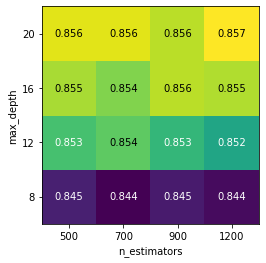

In [27]:
plot_grid_search_results(randf_grid1)

### Observation
* since the max depth and n_estimators are at the edge of the grid search, I am going to widen the grid in that direction for both parameters to see if there is a better range that I should be searching in:

In [28]:
param_grid2 = {'n_estimators': [1000, 1100, 1200, 1400],
                    'max_depth': [20, 40, 60, 80]}

randf_grid2 = GridSearchCV(RandomForestClassifier(random_state=37), param_grid2, cv=7, n_jobs=-1, return_train_score=True, scoring='accuracy')

randf_grid2.fit(X_train_scale, y_train)

GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=37), n_jobs=-1,
             param_grid={'max_depth': [20, 40, 60, 80],
                         'n_estimators': [1000, 1100, 1200, 1400]},
             return_train_score=True, scoring='accuracy')

In [29]:
print_grid_search_result(randf_grid2)

Best parameters and their respective values are: 
max_depth = 20
n_estimators = 1400
Mean training score = 0.998
Mean validation score = 0.858


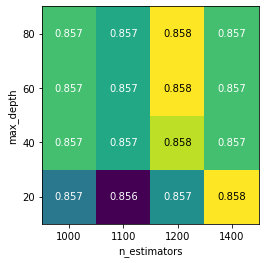

In [30]:
plot_grid_search_results(randf_grid2)

### Observation

* It is clear that expanding the grid for those parameters made very little difference, and the model is still overfitting quite a bit since it has a training score of 0.998. I am going to attempt one more grid search with some of the other hyper parameters to see if those will yield better results

In [31]:
param_grid3 = {'max_features': ['auto', 'sqrt', 'log2'],
                'min_samples_leaf': [1,2,3],
                'min_samples_split': [2,4,6]}

randf_grid3 = GridSearchCV(RandomForestClassifier(random_state=37), param_grid3, cv=7, n_jobs=-1, return_train_score=True, scoring='accuracy')

randf_grid3.fit(X_train_scale, y_train)

GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=37), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6]},
             return_train_score=True, scoring='accuracy')

In [32]:
print_grid_search_result(randf_grid3)

Best parameters and their respective values are: 
max_features = auto
min_samples_leaf = 1
min_samples_split = 2
Mean training score = 1.000
Mean validation score = 0.858


*NOTE: I Did not plot this confusion matrix since the function for plotting only works for 2 hyperparameters. In addition, the scores are almost identitcal as shown below:*

### Observation
Seeing almost the same results by attempting to tune other parameters. Interestingly enough, the default model with no hyperparameter tuning actually yields almost the exact same results no matter what hyperparameter's are tuned. As we can see from below, the scores between the default models and the 3 tuned models are almost exactly the same:

* Default model: Training score = 1.000, Validation score = 0.858
* Grid search 1: Training score = 0.998, Validation score = 0.857
* Grid search 2: Training score = 0.998, Validation score = 0.858
* Grid search 3: Training score = 1.000, Validation score = 0.858

I find this quite interesting in that there is so little variance in the scores no matter what parameters (at least ones I have selected) are tuned. I assuming this is due to the fact that trees tend to overfit on the training data. However, a RandomForest is supposed to help reduce this overfitting by averaging the results of the random trees, yet it seems this is just the scores that it converges to everytime despite the parameter tuning. Very interesting. I will need to think more on this one, as its not totally clear to me what could be causing this, but I think it is something that will click in the future!

### 6.2 Grid search for SVC

In [33]:
param_grid_svc1 = {'C': [0.0001, 0.001, 0.01, 0.1],
                    'gamma': [0.1, 1, 10, 100]}

svc_grid1 = GridSearchCV(SVC(), param_grid_svc1, cv=7, n_jobs=4, return_train_score=True, scoring='accuracy')

In [34]:
svc_grid1.fit(X_train_scale, y_train)

GridSearchCV(cv=7, estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1],
                         'gamma': [0.1, 1, 10, 100]},
             return_train_score=True, scoring='accuracy')

In [35]:
print_grid_search_result(svc_grid1)

Best parameters and their respective values are: 
C = 0.1
gamma = 0.1
Mean training score = 0.842
Mean validation score = 0.831


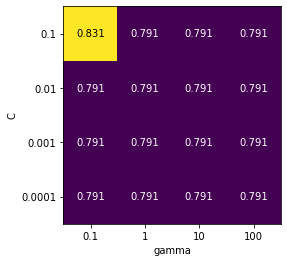

In [36]:
plot_grid_search_results(svc_grid1)

### Observation
* Again here, my initial grid search best parameters are right at the edge of the grid (C=0.1, gamma=0.1), I will expand the parameters and try searching again to see if I can get some better results

In [37]:
param_grid_svc2 = {'C': [0.1, 1, 10, 20],
                    'gamma': [0.05, 0.1, 0.3, 0.5]}

svc_grid2 = GridSearchCV(SVC(), param_grid_svc2, cv=7, n_jobs=4, return_train_score=True, scoring='accuracy')

In [38]:
svc_grid2.fit(X_train_scale, y_train)

GridSearchCV(cv=7, estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.1, 1, 10, 20], 'gamma': [0.05, 0.1, 0.3, 0.5]},
             return_train_score=True, scoring='accuracy')

In [39]:
print_grid_search_result(svc_grid2)

Best parameters and their respective values are: 
C = 1
gamma = 0.1
Mean training score = 0.907
Mean validation score = 0.856


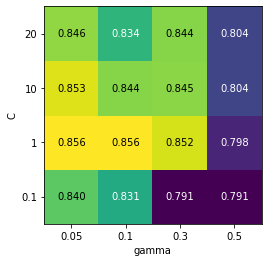

In [40]:
plot_grid_search_results(svc_grid2)

### Observation
Training and validation scores both went up to 0.907 and 0.856 respectively, and although it appears I am still likely overfitting slightly, I am going to settle with this performance. 

### 6.3 Grid search for GradientBoostingClassifier

In [41]:
param_grid_gradb1 = {'n_estimators': [50, 100, 200],
                    'learning_rate': [0.001, 0.01, 0.1, 1.0]}

gradb_grid1 = GridSearchCV(GradientBoostingClassifier(random_state=22), param_grid_gradb1, cv=7, n_jobs=4, return_train_score=True, scoring='accuracy')

In [42]:
gradb_grid1.fit(X_train_scale, y_train)

GridSearchCV(cv=7, estimator=GradientBoostingClassifier(random_state=22),
             n_jobs=4,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='accuracy')

In [43]:
print_grid_search_result(gradb_grid1)

Best parameters and their respective values are: 
learning_rate = 0.1
n_estimators = 200
Mean training score = 0.910
Mean validation score = 0.852


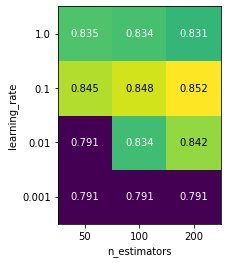

In [44]:
plot_grid_search_results(gradb_grid1)

### Observation
It appears that I am overfitting the data since the training score is 0.947 and the validation score is 0.856. I am going to try experimenting with some of the other hyperparameters to see if I can tame things a bit more:

In [45]:
param_grid_gradb2 = {'n_estimators': [200, 300, 400],
                    'learning_rate': [0.001, 0.01, 0.1, 1.0]}

gradb_grid2 = GridSearchCV(GradientBoostingClassifier(random_state=22), param_grid_gradb2, cv=7, n_jobs=4, return_train_score=True, scoring='accuracy')

In [46]:
gradb_grid2.fit(X_train_scale, y_train)

GridSearchCV(cv=7, estimator=GradientBoostingClassifier(random_state=22),
             n_jobs=4,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [200, 300, 400]},
             return_train_score=True, scoring='accuracy')

In [47]:
print_grid_search_result(gradb_grid2)

Best parameters and their respective values are: 
learning_rate = 0.1
n_estimators = 400
Mean training score = 0.941
Mean validation score = 0.858


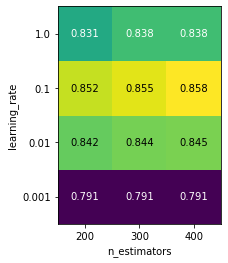

In [48]:
plot_grid_search_results(gradb_grid2)

### Observation
* Training score has improved to 0.941, and validation has improved to 0.858. A very slight improvement from the previous search which yielded 0.910 and 0.852 for training and validation respectively. It does appear to make it over fit a bit more, however the validation score did improve, so I am going to take this performance as acceptable.

## 7. Results

### 7.1 Training and Validation Scores of the three tuned (best) models 

#### RandomForestClassifier
- Training score: 0.998
- Validation score: 0.858

#### SVC
- Training score: 0.907
- Validation score: 0.856

#### GradientBoostingClassifier
- Training score: 0.941
- Validatioon score: 0.858

### Observation
- It is a very close tie in performance between all three of the best tuned models. There is only a 0.002 difference in the validation scores between all three of the models. Based on this, it appears that all will have a very similar performance. I am going to train all of them with their respective best parameters and then test them all on the validation data to see if there is any variance between the models when using unseen data. 

## 8. Evaluate on Testing Data
### 8.1 Training


In [49]:
models = [RandomForestClassifier(random_state=37, max_depth=20, n_estimators=1400), 
            GradientBoostingClassifier(random_state=22, learning_rate=0.1, n_estimators=400), 
            SVC(C=1, gamma=0.1)]

for model in models:
    model.fit(X_train_scale, y_train)

### 8.2 Testing

In [50]:
from sklearn.metrics import classification_report

for model in models:
    print(model.__class__.__name__ + ":\n")
    print(classification_report(y_test, model.predict(X_test_scale)))

RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1044
           1       0.75      0.49      0.59       276

    accuracy                           0.86      1320
   macro avg       0.82      0.72      0.75      1320
weighted avg       0.85      0.86      0.85      1320

GradientBoostingClassifier:

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1044
           1       0.73      0.57      0.64       276

    accuracy                           0.86      1320
   macro avg       0.81      0.75      0.78      1320
weighted avg       0.86      0.86      0.86      1320

SVC:

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1044
           1       0.75      0.50      0.60       276

    accuracy                           0.86      1320
   macro avg       0.81      0.73      0.76      1320
weighted avg  

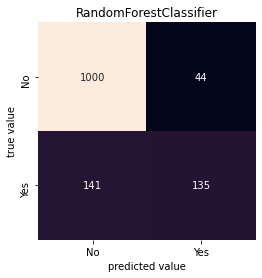

In [51]:
plot_confusion_matrix(y_test, models[0].predict(X_test_scale), enc.classes_, models[0].__class__.__name__)

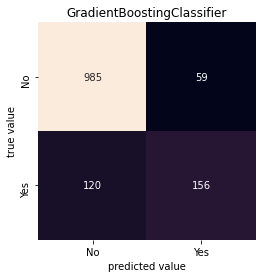

In [52]:
plot_confusion_matrix(y_test, models[1].predict(X_test_scale), enc.classes_, models[1].__class__.__name__)

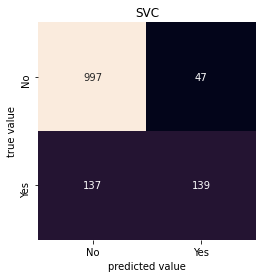

In [53]:
plot_confusion_matrix(y_test, models[2].predict(X_test_scale), enc.classes_, models[2].__class__.__name__)

### Observation
All three of the models are showing very similar performance on the testing data. 

## 9 Final Results

Below are the final scores for all three of the models after tuning them to their best hyperparameters and testing on the unseen test data:

### GradientBoostingClassifier
* Precision = 0.82
* Recall = 0.72
* F1-score = 0.75
* FP = 141
* FN = 44

### RandomForestClassifier
* Precision = 0.81
* Recall = 0.75
* F1-score = 0.78
* FP = 120
* FN = 59

### SVC
* Precision = 0.81
* Recall = 0.73
* F1-score = 0.76
* FP = 137
* FN = 47


## 10 Interpretation

### Best model
It is clear from the results that all three of the best models yield very similar performance. Their F1 scores are only separated by 0.03 from the highest to the lowest score which is quite close to each other. In order to decide upon which model is the best out of these three, I am focussing in on how many false negative predictions each of the models are making. 

I am focussing on the false negatives as I think that this is the worse scenario out of the two potential false predictions, as it would be less than ideal if you are using this model to predict the weather and then it predicts there is no rain, so you leave all your rain gear at home, to only find that it has begun raining. Whereas it predicts that it will rain, and it doesn't, the only real harm is that now you brought your umbrella to work but do not have to end up using it. I think that I personally would prefer that to happen than be caught without my rain gear when the rain is coming. So, with that in mind, I feel the best of these three models should be the one that is making the least amount of mistakes. 

I could also tune them to have a higher threshold like we did in Lab 3 to reduce the amount of false negatives, but I feel this project is already quite long and I explored these models quite in depth, and I think I will leave experimenting with a higher threshold for future work. Furthermore, of the 1320 predictions made by each model, the ranges of false negatives are only 120-141, which is 9% - 11%. In this scenario since the absolute worst case scenario is the models thinks it wont rain and it does, the consequences really are not that dire, so I think that this is an acceptable performance, but like anything, there is always room for improvement.

So, based on that criteria, I conclude that the best model for this data set and predicting whether or not it will rain tomorrow is the *RandomForestClassifier* since it yields the highest f1-score of 0.78, alongside making the least amount of false negative predictions, which totalled 120. 


### Overall interpretation

Overall, I was quite surprised by how similar the performance is between the three models, this is quite interesting to me as it seems all of them generalize to roughly the same performance. Even more interesting was how despite whatever hyperparameters were selected for the RandomForestClassifier, the performance was almost identical to the default model. 

I am not quite sure what is causing this at this point, could potentially have something to do with how I pre-processed the data, or it could just be the way this data set is when used for machine learning. I think that this is something that I will have to re-visit in the future when I am more confident and have more experience with machine learning. 

My plan was to explore how machine learning can be used to make accurate weather predictions based on historical data. Of the 5 initial models I was exploring, I have found three models all within very close performance of one another that are up for the task of predicting whether or not it is going to rain in Australia tomorrow. 

Although they are not perfect, I believe that they could be used as a quick check in the morning if you need to pack an umbrella or not. After completing this project, I believe that it shows machine learning can be utilized on historical weather data to make some accurate predictions on unseen data. I am also sure that this is something that is actively being used around the globe today since there is such a vast amount of weather data that can be harvested for this task. 

I do find this fascinating that we can use historical labelled data, and these algorithms, to make quite accurate predictions about something that changes as often as the weather. I think that this project helped me gain some more confidence in exploring new areas to apply machine learning, as well as discover some other interesting facets that need to be investigated further!

## 11 Reflection

In retrospect, I feel I learned quite a bit from this lab. Having the mixture of categorical and numerical data helped me get more of a feel for what is required when wrangling datasets, furthermore, dealing with data sets with many null values. I also feel much more comfortable grid searching and interpreting the results from those grid searches. I am still a bit perplexed as to why the RandomForestClassifier seems to reach almost the same levels of performance regardless of hyperparameter selection/tuning, but as mentioned previously, this is definitely a take away for me and will definitely circle back to try and determine an answer in the future!

With regards to the proposal, since I was using lab 3 as a roadmap, I followed the general structure/flow of that lab to explore this data and train machine learning models for the weather prediction. Where I deviated from the lab was during the grid searching portion, as in the lab, we only had to grid search once for each model where we ended up getting results that were in the middle of our grid search and yielded good performance. 

I ran into the issues of having models that were overfitting the data by quite a bit, and almost always having the grid searches end up selecting values that were right at the edge of the search - meaning I should expand it, however this led to almost identical results in the case of the RandomForestClassifier, and only a very marginal improvements in both SVC and the GradientBoostingClassifier. 

After experimenting with different hyperparameter's and ranges, I settled in on the performance of the models but then noticed that all of them were almost identical in their overall performance. Another very interesting facet. One that I also am not 100% sure on what would cause this to be the case, again, some more food for thought in the future. 

I also deviated a bit from the lab 3 at the end as I did not feel it was necessary in this case to fine tune the threshold since the consequences of the model making a mistake really are not that dire. Worst case scenario it is an inconvenience to get caught in the rain without your rain gear, but it certainly could put a damper on the day!

In summary, I feel I explored and created 3 models that have decent performance at predicting whether or not it will rain tomorrow in Australia. This was a great learning experience and I look forward to exploring more datasets and models in the future!